# INFO 2950 Final Project Phase II  
Mary Kolbas (mck86)  
Tammy Zhang (tz332)  


## Research Question

**What factors about the environment and time affect how many and what species of birds are sighted at backyard feeders in New York state? Can we build a model to predict how many and what species of birds are expected based on the location/environment features, or are the bird sightings mostly random or independent of the feeder location/conditions?**

- From our data exploration, when looking at the top 25 most popular birds (based on total sighting), we can explore the effect of certain environmental conditions (snow levels, housing density, etc.) or time (month, time of day, etc.) on sighting frequency and species. We want to explore whether these patterns can be explained by bird behavior such as migration patterns and seasonality or whether other factors relating to the environment have a significant impact. From domain knowledge, we already know several of these bird species are local to the area (non-migratory). This makes our question especially interesting for cases where a species' sightings have unexplained peaks.



## Data Cleaning (Appendix, Draft)
Project FeederWatch is a citizen-science-based data source supported by the Cornell Lab of Ornithology, which collects observations of bird species at backyard feeders and habitats all over the world in an annual November-April survey.

Our raw file comes from the [Project FeederWatch](https://feederwatch.org/explore/raw-dataset-requests/) 2021 New York checklist data and site description data. This file is extremely large and has sightings from about November 2020 to April 2021. After downloading the file, we used an R function provided by FeederWatch to conduct taxonomic roll-up and zero-filling, two procedures recommended by FeederWatch to limit errors. The R code used to clean is provided [here](https://engagement-center.github.io/Project-FeederWatch-Zerofilling-Taxonomic-Rollup-Public/).

1. *Taxonomic roll-up*: A process of combining observations that were recorded under different species codes but would best be treated as the same species. For example, some observers may take note of subspecies, which are then recorded under different codes than the overall species when they should logically be combined.

2. *Zero-filling*: adding counts of 0 for all species that were not recorded at an observation, essential for accounting for the fact that observation data is inherently presence-only.

We decided to focus our research on only sighting in New York State, which is still a rather large subset of the data. As of right now, we have decided to drop `latitude` and `longitude`. We also dropped irrelevant columns, such as `ENTRY_TECHNIQUE` (a variable indicating method of site localization), `PROJ_PERIOD_ID` (calendar year of end of FeederWatch season), `sub_id` and `obs_id` (indentifiers for checklist or species respectively), `effort_hrs_atleast` (survey time), and `DATA_ENTRY_METHOD` (web/mobile/paper).

In [14]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

In [4]:
# importing sql
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [4]:
# reading in raw provided data
csv = pd.read_csv("rolled_up_NY_df.csv")

In [5]:
# making dataframe
df = pd.DataFrame(csv)

In [6]:
new_columns = list(map(str.lower, df.columns))
df.columns = new_columns

In [7]:
# dropping irrelevant columns
df.drop(['unnamed: 0', '...1', 'latitude', 'longitude', 'entry_technique', 'proj_period_id', 'reviewed', 'sub_id', 'obs_id',
        'effort_hrs_atleast', 'data_entry_method'], axis= 1, inplace= True)

In [8]:
# dropping observations that are not valid
df = df[df['valid'] == 1]

In [9]:
df.head()

,loc_id,subnational1_code,month,day,year,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast,species_code,how_many,plus_code,valid
0,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,1,NaN,1
1,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
2,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
3,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
4,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1


We also created new dataframes to only specify the top species for our data exploration.

`species_limited_df` is a slice of `df` holding the data only for the top (most frequent) species.

In `snow_df`, we have created bins (`snow_category`) to categorize the snowfall for all sightings where snow depth is not null.

The `species_limited_time` dataframe is a manipulated version of `species_limited_df` with a datetime object, allowing for time series calculations and comparisons.

The `df_timeofday` dataframe narrows the data down to only entries where one of the four sighting periods of the two-day observation period occur. In otherwords, only the entries such that `day1_am` + `day1_pm` + `day2_am` + `day2_pm` = 1, and also limits to the top 25 species. This allows us to plot differences in observation counts based on time of day (morning vs afternoon) in our exploratory section. 

In [10]:
# making a list of the 10 most frequently observed species
frequent_species = df['species_code'].value_counts()[:1].index

# creating new dataframe limited to just the most frequent species observations
species_limited_df = df[df['species_code'].isin(frequent_species)]

species_limited_df.to_csv("bluejay_df.csv")

By convention, bird species are stored as 6-letter codes. However, this makes readability and interpretability more difficult later on. To remedy this, we can do an inner join with a taxonomy table provided by FeederWatch so we can add a column with the species full common name.

In [46]:
# joining common names
species_translate_df = pd.DataFrame(pd.read_csv("PFW-species-translation-table.csv"))
%sql species_limited_df << SELECT loc_id, subnational1_code, month, day, year, species_limited_df.species_code, how_many, valid, day1_am, day1_pm, day2_am, day2_pm, snow_dep_atleast, american_english_name AS species_name FROM species_limited_df INNER JOIN species_translate_df ON species_limited_df.species_code = species_translate_df.species_code;

Returning data to local variable species_limited_df


In [47]:
species_limited_df

,loc_id,subnational1_code,month,day,year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast,species_name
0,L6731705,US-NY,11,14,2020,blujay,1,1,1,1,1,1,0.000,Blue Jay
1,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,0.000,Blue Jay
2,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,0.000,Blue Jay
3,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,0.000,Blue Jay
4,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,0.000,Blue Jay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,L2404002,US-NY,2,10,2021,blujay,0,1,0,0,1,0,0.001,Blue Jay
246004,L2404002,US-NY,2,10,2021,blujay,0,1,0,0,1,0,0.001,Blue Jay
246005,L2404002,US-NY,2,10,2021,blujay,0,1,0,0,1,0,0.001,Blue Jay
246006,L2404002,US-NY,2,10,2021,blujay,0,1,0,0,1,0,0.001,Blue Jay


In [48]:
# dropping rows where snow depth was null
snow_df = species_limited_df.dropna(subset=['snow_dep_atleast'])

# creating new category with string corresponding to each value in snow depth (for binning in the line plots)
snow_df['snow_category'] = 'No Snow'
snow_df.loc[snow_df['snow_dep_atleast'] == 0.001, 'snow_category'] = '< 5 cm'
snow_df.loc[snow_df['snow_dep_atleast'] == 5.000, 'snow_category'] = '5 to 15 cm'
snow_df.loc[snow_df['snow_dep_atleast'] == 15.001, 'snow_category'] = '> 15 cm'

/var/folders/n9/xxpjsdt533588521bftbd6qm0000gn/T/ipykernel_45930/3836606446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_df['snow_category'] = 'No Snow'


In [49]:
species_limited_time = species_limited_df

# create a column that puts month, date, year in one string
species_limited_time['datestring'] = species_limited_time['month'].astype(str) + "/" + species_limited_time['day'].astype(str) + "/" + species_limited_time['year'].astype(str)

#turn datestring into datetime and drop datestring
species_limited_time['date_time'] = pd.to_datetime(species_limited_time['datestring'], format='%m/%d/%Y')
species_limited_time.drop(columns="datestring")

#grouped by date_time (datetime object)
species_limited_time = species_limited_time.groupby(["species_name", "date_time"]).mean()[['how_many','snow_dep_atleast']]
species_limited_time.head()

how_many  snow_dep_atleast
species_name date_time                             
Blue Jay     2020-11-13  0.285714          0.000000
             2020-11-14  0.292822          0.003103
             2020-11-15  0.269316          0.024390
             2020-11-16  0.264320          0.055487
             2020-11-17  0.322034          0.203332

In [50]:
#duplicating df
df_timeofday = df

#only using entries with unique time sightings (they only recorded sightings at one of the 4 time periods as opposed
#to multiple sightings aggregated)
df_timeofday = df_timeofday[df_timeofday['day1_am'] + df_timeofday['day1_pm'] + df_timeofday['day2_am'] + df_timeofday['day2_pm'] == 1]

# creating new category with string corresponding to unique sighting day1_am, day1_pm, day2_am, day2_pm
df_timeofday['unique_time'] = 'day1_am'
df_timeofday.loc[df_timeofday['day1_pm'] == 1, 'unique_time'] = 'day1_pm'
df_timeofday.loc[df_timeofday['day2_am'] == 1, 'unique_time'] = 'day2_am'
df_timeofday.loc[df_timeofday['day2_pm'] == 1, 'unique_time'] = 'day2_pm'

#limit to only top species 
df_timeofday_specieslimited = df_timeofday[df_timeofday['species_code'].isin(frequent_species)]


/var/folders/n9/xxpjsdt533588521bftbd6qm0000gn/T/ipykernel_45930/3062357538.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeofday['unique_time'] = 'day1_am'


We also created a joined dataframe `join_df` that combines `species_limited_df` and `sites_df` using an `INNER JOIN` on `loc_id`, which provides us with information about the environment in which the observation entry took place. By doing this, we lose about half of our `species_limited_df` data entries because their location is not described in `sites_df`. 

In [10]:
# reading in raw provided data
csv_sites = pd.read_csv("PFW_count_site_data_public_2021.csv")

#creating dataframe
sites_df = pd.DataFrame(csv_sites)

# keeping only the columns that will be involved in analysis
sites_df = sites_df[['loc_id', 'proj_period_id', 'yard_type_pavement', 'yard_type_garden', 'yard_type_landsca', 'yard_type_woods', 
'yard_type_desert','hab_dcid_woods', 'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard', 'hab_park', 'hab_water_fresh', 
'hab_water_salt', 'hab_residential','hab_industrial', 'hab_agricultural', 'hab_desert_scrub', 'hab_young_woods', 'hab_swamp', 
'hab_marsh', 'brsh_piles_atleast', 'water_srcs_atleast', 'bird_baths_atleast', 'nearby_feeders', 'squirrels', 'cats', 'dogs', 'humans',
'housing_density', 'population_atleast']]

sites_df

,loc_id,proj_period_id,yard_type_pavement,yard_type_garden,yard_type_landsca,yard_type_woods,yard_type_desert,hab_dcid_woods,hab_evgr_woods,hab_mixed_woods,...,brsh_piles_atleast,water_srcs_atleast,bird_baths_atleast,nearby_feeders,squirrels,cats,dogs,humans,housing_density,population_atleast
0,L100016,PFW_2002,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
1,L100016,PFW_2003,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0
2,L100016,PFW_2004,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0
3,L100016,PFW_2005,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0
4,L100016,PFW_2006,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254350,L999923,PFW_2010,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
254351,L99994,PFW_2002,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,25001.0
254352,L99996,PFW_2002,0.0,0.0,1.0,1.0,0.0,1.0,NaN,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,5001.0
254353,L9999665,PFW_2020,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,100001.0


In [40]:
#join species_limited_df (sightings of top species) with sites_df (location details)
#%sql join_df << SELECT species_limited_df.loc_id, subnational1_code, species_code, how_many, snow_dep_atleast, species_name, date_time, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, population_atleast, FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;

#changed join_df to have these columns for the hypothesis testing section
%sql join_df << SELECT month, day, year, species_limited_df.loc_id, species_code, species_name, how_many, date_time, day1_am, day1_pm, day2_am, day2_pm, Light_Snow, Heavy_Snow, No_Snow, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, population_atleast, FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;

Returning data to local variable join_df


In [41]:
join_df.head()

,month,day,year,loc_id,species_code,species_name,how_many,date_time,day1_am,day1_pm,...,brsh_piles_atleast,water_srcs_atleast,bird_baths_atleast,nearby_feeders,squirrels,cats,dogs,humans,housing_density,population_atleast
0,4,24,2021,L10011987,blujay,Blue Jay,0,2021-04-24,1,0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,5001.0
1,4,24,2021,L10011987,blujay,Blue Jay,0,2021-04-24,1,0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,5001.0
2,1,30,2021,L10012113,blujay,Blue Jay,0,2021-01-30,1,0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,5001.0
3,4,29,2021,L10049605,blujay,Blue Jay,0,2021-04-29,1,1,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,25001.0
4,4,29,2021,L10049605,blujay,Blue Jay,0,2021-04-29,1,1,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,25001.0


In [54]:
# taking only quantitative columns to prepare for correlation matrix
quantitative_join_df = join_df[['how_many', 'snow_dep_atleast', 'yard_type_pavement', 'yard_type_garden', 
                                'yard_type_landsca', 'yard_type_woods', 'yard_type_desert', 'hab_dcid_woods', 
                               'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard', 'hab_park', 'hab_water_fresh', 
                                'hab_water_salt', 'hab_residential', 'hab_industrial', 'hab_agricultural', 
                               'hab_desert_scrub', 'hab_young_woods', 'hab_swamp', 'hab_marsh', 'brsh_piles_atleast', 
                                'water_srcs_atleast', 'bird_baths_atleast', 'nearby_feeders', 'squirrels', 'cats', 'dogs', 
                                'humans', 'housing_density', 'population_atleast']]

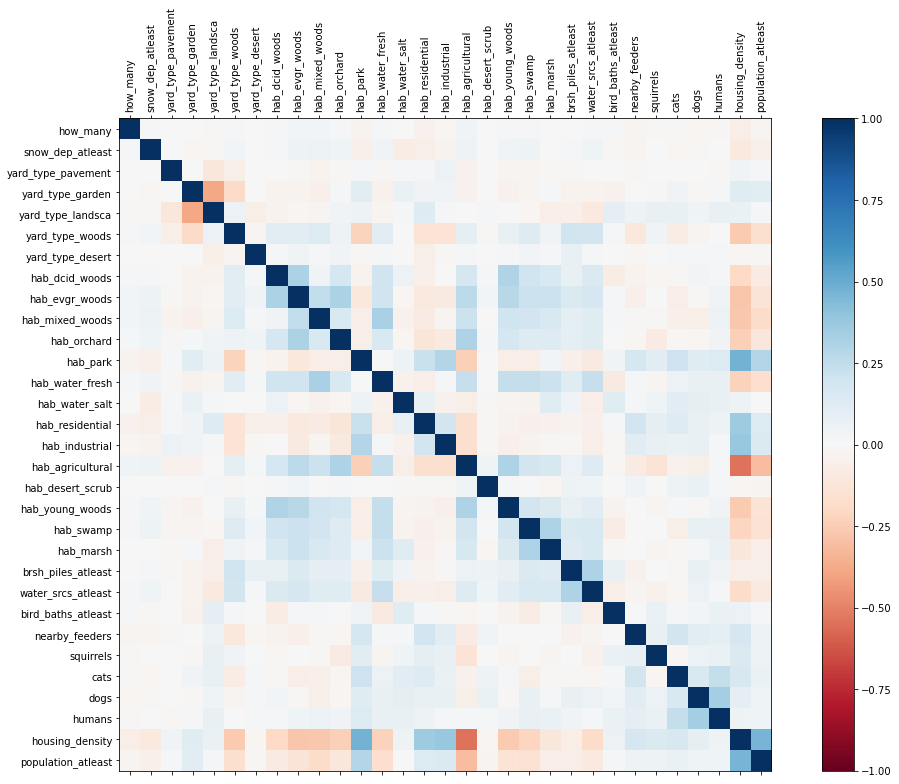

In [55]:
corr = quantitative_join_df.corr()

fig = plt.figure()
fig.set_size_inches(18, 12)
ax = fig.add_subplot() 
fig.colorbar(ax.matshow(corr, cmap='RdBu', vmin=-1, vmax=1)) 

ax.set_xticks(range(len(corr.columns))) 
ax.set_xticklabels(corr.columns)
for tick in ax.get_xticklabels(): 
        tick.set_rotation(90)

ax.set_yticks(range(len(corr.columns))) 
ax.set_yticklabels(corr.columns)

plt.show()

## Data Description

Our data in `df` comprises of observations (rows) of bird sightings in NY state between November 2020 and April 2021. It has attributes (columns) of the following: 
- `loc_id`: Unique identifier for each survey site
- `subnational1_code`: Country abbreviation and State or Province abbreviation of each survey site. 
- `Month`: Month of 1st day of two-day sighting
- `Day`: Month of 1st day of two-day sighting
- `Year`: Year of 1st day of two-day sighting
- `species_code`: Bird species observed, stored as 6-letter species codes
- `how_many`: Maximum number of individuals seen at one time during observation period
- `valid`: Validity of each observation based on flagging system
- `day1_am`: binary indicating if observer watched during morning of count Day 1
- `day1_pm`: binary indicating if observer watched during afternoon of count Day 1
- `day2_am`: binary indicating if observer watched during morning of count Day 2
- `day2_pm`: binary indicating if observer watched during afternoon of count Day 2
- `snow_dep_atleast`: Participant estimate of minimum snow depth


In our case, we have constrained our data to only look at entries from NY state (`subnational1_code` = "US-NY") and are valid (`valid` = 1). 

Our data from `species_translate_df` contains a species translation table provided by FeederWatch. The most relevant columns are as follows:
- `species_code`: variable storing a 6 letter string representing a species code
- `american_english_name`: variable storing a string representing the full common name of the species in English

We use `species_translate_df` in an inner join during Data Cleaning to create `df`.

In [ ]:
species_translate_df.head()

In [ ]:
df.head()

Our data in `join_df` comprises of observations (rows) of bird sightings in NY state between November 2020 and April 2021 from `df`, with additional columns from `sites_df`, which has attributes regarding location/environment details based on a unique location id. This dataframe has new additional attributes (columns) of the following: 


- `proj_period_id`: Calendar year of end of FeederWatch season
- `yard_type_pavement`: binary variable whether location is pavement (no vegetation)
- `yard_type_garden`: binary variable whether location is a garden/courtyard 
- `yard_type_landsca`: binary variable whether location is a landscaped yard
- `yard_type_woods`: binary variable whether location is natural vegetation
- `yard_type_desert`: binary variable whether location is a natural or landscaped desert
- `hab_dcid_woods`: binary variable whether location is within 0.5mi from deciduous woods
- `hab_evgr_woods`: binary variable whether location is within 0.5mi from evergreen woods
- `hab_dcid_woods`: binary variable whether location is within 0.5mi from deciduous woods
- `hab_mixed_woods`: binary variable whether location is within 0.5mi from mixed deciduous-evergreen woods
- `hab_orchard`: binary variable whether location is within 0.5mi from an orchard
- `hab_park`: binary variable whether location is within 0.5mi from a park
- `hab_water_fresh`: binary variable whether location is within 0.5mi from fresh water
- `hab_water_salt`: binary variable whether location is within 0.5mi from salt water
- `hab_residential`: binary variable whether location is within 0.5mi from a residential area
- `hab_industrial`: binary variable whether location is within 0.5mi from an industrial or commercial area
- `hab_agricultural`: binary variable whether location is within 0.5mi from an agricultural fields
- `hab_desert_scrub`: binary variable whether location is within 0.5mi from a desert or scrub
- `hab_young_woods`: binary variable whether location is within 0.5mi from an secondary growth woods
- `hab_swamp`: binary variable whether location is within 0.5mi from a swamp (wooded)
- `hab_marsh`: binary variable whether location is within 0.5mi from a marsh
- `brsh_piles_atleast`: Minimum number of brush piles within the count area
- `water_srcs_atleast`: Minimum number of water sources within the count area
- `bird_baths_atleast`: Minimum number of bird baths within the count area
- `nearby_feeders`: binary variable whether other feeders (aside from those maintained by participant) within 90m of the count site
- `squirrels`: binary variable whether squirrels take food from the feeders at least 3 times a week
- `cats`: binary variable whether cats are active within 30m of the feeder for at least 30 min 3 times a week
- `dogs`: binary variable whether dogs are active within 30m of the feeder for at least 30 min 3 times a week
- `humans`: binary variable whether humans are active within 30m of the feeder for at least 30 min 3 times a week
- `housing_density`: Participant-defined description of the housing density of the neighborhood, where 1 = "rural", 2 = "rural/suburban", 3 = "suburban", 4 = "urban"
- `population_atleast`: categorical variable expressing participant estimated population of city or town

In [ ]:
join_df.head()

This dataset was created by Project FeederWatch for researchers seeking to conduct formal analyses, but also to have this data be freely accessible to students, journalists, and the general public. The data is collected by contributors and participants. It is created and supported by Cornell Lab and Birds Canada. Since 2016, Project FeederWatch has been sponsored by Wild Bird Unlimited and the National Science Foundation.

Because this is community-curated data, there are many processes that may have influenced what data was observed/recorded and what was not, including mislogging information. This dataset involved a validity checker that flags odd sightings and has them checked by a reviewer. The data we will be using for this project drops invalid observations. FeederWatch also notes there may be mislogged locations in `subnational1_code` represented "XX" locations, which we dropped when choosing to only look at NY state data. 

Because this is community-currated data, there is also volunteer bias in observations, as certain locations or species may be more common in the dataset due to active and dedicated users. However, many users are also very knowledgeable about birds, and therefore can provide a lot of information and identification resources. 

Preprocessing was done to change the very large dataset into a smaller, more manageable one with relevant columns. We filtered the data, dropped irrelevant columns, and added columns to bin data or aid in time series analysis. Details on the Data Cleaning process can be found in the appendix. 

Our raw datasource can be found [here](https://cornell.box.com/s/wzdfg3lotvqr6wc5ik680jzit8fu3t7s) via Cornell Box, or on the [FeederWatch Website](https://feederwatch.org/explore/raw-dataset-requests/).

## Data Limitations

There are some notable limitations with our dataset - as FeederWatch notes on their website, the sheer scale of the data collected and the nature of citizen science involving a large number of participants taking unverifiable observations in varying circumstances mean that the data inherently will have imperfections. For example, some species may appear highly similar to each other, which may cause increased rates of misidentification for those species. When proceeding with further analysis, this effect can be limited somewhat by grouping together similar species into general families. FeederWatch also notes that it is likely for meaningful biological patterns to still emerge from the data despite the possibility of erroneous entries.

A significant limitation of the data is described by FeederWatch as follows: "a recorded observation is a function of both the biological event (number of species actually present) and the observation process (probability that an individual, when present, will be observed)". Without using formal estimation of detection probabilities, it cannot be said that higher numbers of observations for a species necessarily indicate that the species is actually present at greater frequencies - we can only make conclusions about observations, not definitively the state of the biological system. 

For example, we cannot say with complete confidence that a species is more frequent in a certain month - only that it is more frequently observed in that month. While a subtle nuance, this is important to consider. For example, it is possible there are species which are very frequent feeder visitors, but are rarely observed due to visiting at times people tend not to be observing, are quick and difficult to identify, etc.

Without taking these limitations into consideration, there is a risk of erroneously representing the data and misleading people about the state of avian biodiversity.

## Preregistration statement

# add a summary of why we want to test these topics and how they're useful for the real world HERE

H0 : p1 = p2  
The proportion of _Accipiter_ observations in each habitat type is equal to the proportion of that habitat type across all observations -> _Accipiter_ is observed at equal frequencies across sites with differing housing densities.

HA : p1 != p2  
The proportion of _Accipiter_ observations in each habitat type is not equal to the proportion of that habitat type across all observations -> _Accipiter_ is more frequently observed at sites with certain housing densities.

We hypothesize this may be the case because birds within the genus _Accipiter_ are birds of prey that need environments where they can find food, which may be easier in environments with small birds congregating around bird feeders or in urban areas where rodents thrive.


H0 : p1 = p2  
The proportion of _Junco_ observations in each habitat type is equal to the proportion of that habitat type across all observations -> _Junco_ is observed at equal frequencies across sites with differing housing densities.

HA : p1 != p2  
The proportion of _Junco_ observations in each habitat type is not equal to the proportion of that habitat type across all observations -> _Junco_ is more frequently observed at sites with certain housing densities.


We hypothesize this may be the case because birds within the genus _Junco_ (small North American sparrows) are a common bird that are typically not phased by humans, therefore we think they may be more likely to be observed in more populated areas.

## Data analysis
Use summary functions like mean and standard deviation along with
visual displays like scatterplots and histograms to describe data.
Provide at least one model showing patterns or relationships between
variables that addresses your research question. This could be a
regression or clustering, or something else that measures some property
of the dataset.

# correlations, exploratative graphs that are RELATED to hypothesis and research question; be concise and remove take out irrelevant things !!! 
# you can edit your hypothesis as you go, show adaptations if so
# TELL A STORY for flow

### Bar Graphs to compare proportion of observations in each habitat vs. proportion of that habitat type across all observations

In [15]:
accipiter_df = pd.read_csv('accipiter.csv')
junco_df = pd.read_csv('junco.csv')
accipiter_df['how_many_binary'] = np.where(accipiter_df['how_many']>0, 1, 0)
junco_df['how_many_binary'] = np.where(junco_df['how_many']>0, 1, 0)

In [16]:
def get_null_actual(df):
    housing_density_freq = df['housing_density'].value_counts() # series with counts for observations with each housing density

    # list of categories mapped to by the floats in housing_density
    housing_density_categories = ["rural", "suburban rural", " suburban", "urban"] 

    actual_in_p = [] # actual "in" proportion p for each housing density of this data
    null_in_p = [] # proportion p for each housing density/overall reported observations
    
    # looping through numbers 1-4, the values in housing_density
    for i in range(1, 5): 
    
        # slicing dataframe into observations that were taken in sites with this housing density and observations that were taken otherwise
        out_df = df[df['housing_density'] != float(i)] # outside this housing density
        in_df = df[df['housing_density'] == float(i)] # inside this housing density


        out_sum = out_df['how_many_binary'].sum() # number of observations this genus was observed outside of sites of this housing density
        in_sum = in_df['how_many_binary'].sum() # number of observations this genus was observed inside sites of of this housing density

        total_sum = out_sum + in_sum # calculate total sum of observed counts

        out_proportion = out_sum/total_sum # proportion of counts observed outside this housing density
        in_proportion = in_sum/total_sum # proportion of counts observed inside this housing density

        actual_in_p.append(in_proportion)
        
        # accessing the number of observations with this housing density and dividing by the total number of observations to normalize
        # aka finding proportion of this housing density relative to total house density data
        housing_proportion = housing_density_freq[float(i)] / df['how_many_binary'].count() 
        
        null_in_p.append(housing_proportion)

    return null_in_p, actual_in_p

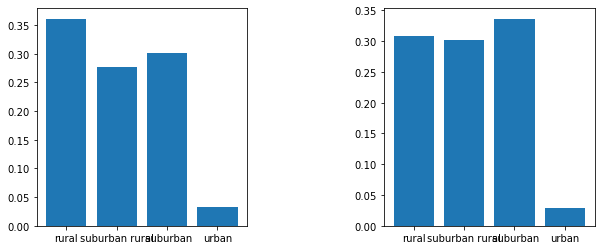

In [17]:
#plotting null (proportion of observations in each housing density category) and actual (proportion of sightings in each housing category)
accipiter_null_in_p, accipiter_actual_in_p = get_null_actual(accipiter_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.subplots_adjust(wspace=0.65)

housing_density_categories = ["rural", "suburban rural", " suburban", "urban"] 
ax1.bar(housing_density_categories, accipiter_null_in_p)
ax2.bar(housing_density_categories, accipiter_actual_in_p)
plt.show()

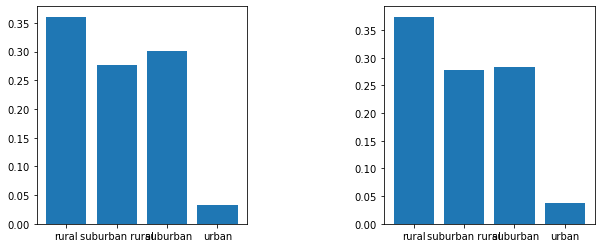

In [18]:
junco_null_in_p, junco_actual_in_p = get_null_actual(junco_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.subplots_adjust(wspace=0.65)
ax1.bar(housing_density_categories, junco_null_in_p)
ax2.bar(housing_density_categories, junco_actual_in_p)
plt.show()

## Evaluation of significance
Use hypothesis tests, simulation, randomization, or
any other techniques we have learned to compare the patterns you observe in the
dataset to simple randomness.

In [21]:
from scipy import stats

print("Accipiter t-test:", stats.ttest_ind(accipiter_null_in_p, accipiter_actual_in_p))
print("Junco t-test:", stats.ttest_ind(junco_null_in_p, junco_actual_in_p))

Accipiter t-test: Ttest_indResult(statistic=-0.010138646842690778, pvalue=0.9922393702868993)
Junco t-test: Ttest_indResult(statistic=-0.002384859013915154, pvalue=0.998174474614944)


#### Results of two sided t-test for difference in proportions
Although from looking at the graphs we saw differing distributions, after running t-tests on both the Accipiter and Junco distributions, we do not see anything statistically significant. In fact, the null hypothesis appears to be quite accurate. This means we fail to reject the null hypothesis that the proportion of Accipiter/Junco observations we see across the four housing densities differs from the proportion of observations from the four housing density proportions. In other words for example, the peak in rural observations is expected to be due to the fact the dataset recieved more reports from bird watchers in rural areas, not that the bird species prefers to be in the rural areas. 

In [79]:
#have to run all this code here because we are using a subset of the data, bluejay_df.csv now instead of everything
csv = pd.read_csv("bluejay_df.csv") 
species_limited_df = pd.DataFrame(csv)
species_limited_df.drop(['Unnamed: 0'],  axis= 1, inplace= True)
species_translate_df = pd.DataFrame(pd.read_csv("PFW-species-translation-table.csv"))
%sql species_limited_df << SELECT loc_id, subnational1_code, month, day, year, species_limited_df.species_code, how_many, valid, day1_am, day1_pm, day2_am, day2_pm, snow_dep_atleast, american_english_name AS species_name FROM species_limited_df INNER JOIN species_translate_df ON species_limited_df.species_code = species_translate_df.species_code;

Returning data to local variable species_limited_df


In [80]:
# dropping rows where snow depth was null
species_limited_df = species_limited_df.dropna(subset=['snow_dep_atleast'])
# creating new category with string corresponding to each value in snow depth (for binning in the line plots)
species_limited_df['snow_category'] = 'No_Snow'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 0.001, 'snow_category'] = 'Light_Snow'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 5.000, 'snow_category'] = '5 to 15 cm'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 15.001, 'snow_category'] = 'Heavy_Snow'
snow_dummies = pd.get_dummies(species_limited_df['snow_category'], drop_first=True)
species_limited_df = pd.concat([species_limited_df, snow_dummies], axis=1)
species_limited_df.drop(['snow_category', 'snow_dep_atleast'],  axis= 1, inplace= True)
# create a column that puts month, date, year in one string
species_limited_df['datestring'] = species_limited_df['month'].astype(str) + "/" + species_limited_df['day'].astype(str) + "/" + species_limited_df['year'].astype(str)
#turn datestring into datetime and drop datestring
species_limited_df['date_time'] = pd.to_datetime(species_limited_df['datestring'], format='%m/%d/%Y')
species_limited_df = species_limited_df.drop(columns=["datestring"])

In [90]:
%sql join_df << SELECT month, day, year, species_limited_df.loc_id, species_code, species_name, how_many, date_time, day1_am, day1_pm, day2_am, day2_pm, Light_Snow, Heavy_Snow, No_Snow, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, population_atleast, FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;

Returning data to local variable join_df


In [39]:
import statsmodels.api as sm
from patsy import dmatrices

mask = np.random.rand(len(join_df)) < 0.8 #go back and use a proper train/test split 
join_df_train = join_df[mask]
join_df_test = join_df[~mask]

expr = 'how_many ~ housing_density + Light_Snow + Heavy_Snow + No_Snow'
y_train, X_train = dmatrices(expr, join_df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, join_df_test, return_type='dataframe')

zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()
print(zip_training_results.summary())

C:\Users\mkolb\anaconda3\envs\info2950\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.352502
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


C:\Users\mkolb\anaconda3\envs\info2950\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                how_many   No. Observations:               929943
Model:             ZeroInflatedPoisson   Df Residuals:                   929938
Method:                            MLE   Df Model:                            4
Date:                 Fri, 18 Nov 2022   Pseudo R-squ.:                 0.02541
Time:                         00:54:05   Log-Likelihood:            -3.2781e+05
converged:                       False   LL-Null:                   -3.3635e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_Intercept           2.4188      0.014    173.917      0.000       2.392       2.446
inflate_housing_density    -0.0271      0.005     -5.314      0.000      -0.037     

In [50]:
zip_predictions = zip_training_results.predict(X_test,exog_infl=X_test)
predicted_counts=np.round(zip_predictions)
actual_counts = y_test['how_many']
print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2)))))

ZIP RMSE=559.7267190334941


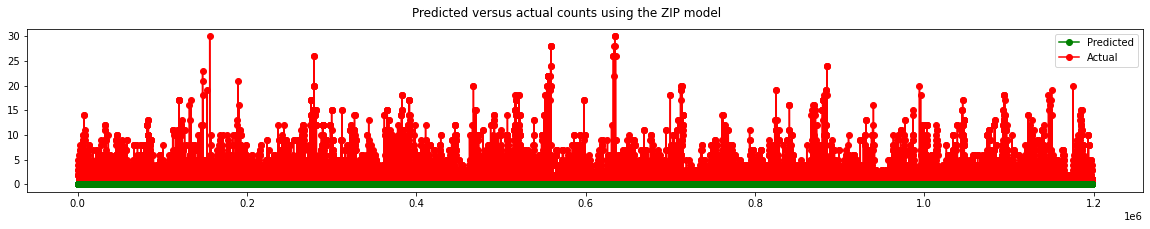

In [57]:
fig = plt.figure()
fig.suptitle('Predicted versus actual counts using the ZIP model')

actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted')
plt.legend(handles=[predicted, actual])
plt.rcParams["figure.figsize"] = (50,3)

plt.show()

In [63]:
predicted_counts.sum()

0.0

### Exploring snow levels and observation counts for the Common Redpoll  
As a secondary research question, we investigated how the Common Redpoll (_Acanthis flammea_) may tend to appear in differently sized groups at feeders when different levels of snow are present. Redpolls are a small, common feeder bird that is known to often appear in groups numbering in the hundreds.

In [5]:
redpoll_df = pd.read_csv("redpoll_df.csv")
print("Mean of redpoll count when snow is 0.0: " + str(redpoll_df[redpoll_df['0.0'] == 1]['how_many'].mean()))
print("Mean of redpoll count when snow is 0.001 - 5.0: " + str(redpoll_df[redpoll_df['0.001'] == 1]['how_many'].mean()))
print("Mean of redpoll count when snow is 5.0 - 15.001: " + str(redpoll_df[redpoll_df['5.0'] == 1]['how_many'].mean()))
print("Mean of redpoll count when snow is 15.001+: " + str(redpoll_df[redpoll_df['15.001'] == 1]['how_many'].mean()))

Mean of redpoll count when snow is 0.0: 10.871540826785104
Mean of redpoll count when snow is 0.001 - 5.0: 13.43467583497053
Mean of redpoll count when snow is 5.0 - 15.001: 14.675405405405405
Mean of redpoll count when snow is 15.001+: 19.30106237148732


At first glance, it appears that the count of redpolls at feeders per observation increases with increasing snow depth. This can be verified with Welch's two-sample t-test to evaluate if the mean counts are statistically significantly different for observations at feeders with no snow compared to observations at feeders with over 15 cm of snow.

Text(0.5, 1.0, 'Counts per observation with 15 cm+ of snow')

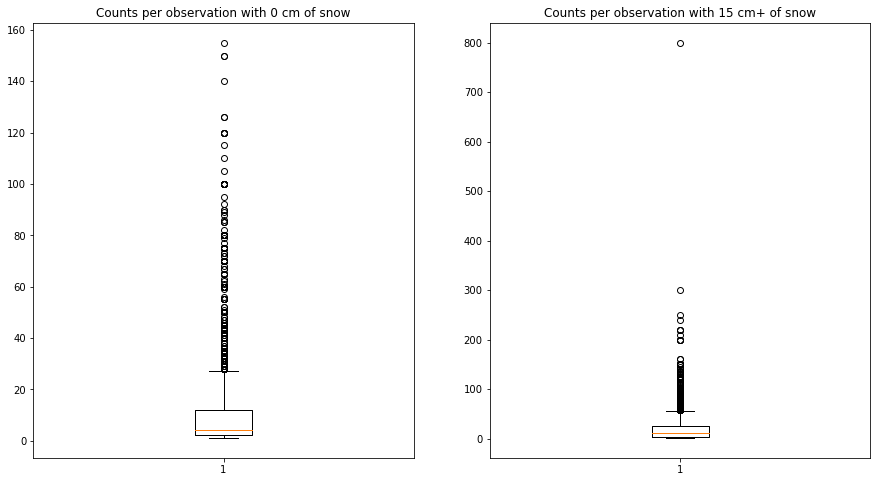

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.boxplot(redpoll_df[redpoll_df['0.0'] == 1]['how_many'])
ax2.boxplot(redpoll_df[redpoll_df['15.001'] == 1]['how_many'])
ax1.set_title("Counts per observation with 0 cm of snow")
ax2.set_title("Counts per observation with 15 cm+ of snow")

In [16]:
stats.ttest_ind(redpoll_df[redpoll_df['0.0'] == 1]['how_many'], redpoll_df[redpoll_df['15.001'] == 1]['how_many'], equal_var = False)

Ttest_indResult(statistic=-17.973353614941498, pvalue=7.843153202349893e-71)

Notably, the t-test produces a surprisingly low p-value, indicating that the true mean of observed redpoll flock size at feeders when there is no snow on the ground is almost certainly not equal to the true mean of flock size when there is significant snow on the ground. This result could speak to behavioral changes throughout winter conditions that drive the formation of larger groups of individuals congregating around and relying heavily on specific feeders.

### Trying Logistic Regression

In [106]:
# dropping rows where snow depth was null
join_df = join_df.dropna(subset=['housing_density'])
# creating new category with string 
join_df['housing_density_bins'] = 'rural'
join_df.loc[join_df['housing_density'] == 2.0, 'housing_density_bins'] = "rural/suburban"
join_df.loc[join_df['housing_density'] == 3.0, 'housing_density_bins'] = "suburban"
join_df.loc[join_df['housing_density'] == 4.0, 'housing_density_bins'] = "urban"

In [107]:
density_dummies = pd.get_dummies(join_df['housing_density_bins'], drop_first=True)

In [108]:
join_df = pd.concat([join_df, density_dummies], axis=1)

In [109]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

In [110]:
join_df = join_df.dropna()
join_df['how_many_binary'] = np.where(join_df['how_many']>0, 1, 0)

X = join_df[['Light_Snow', 'Heavy_Snow', 'No_Snow', "rural/suburban", "suburban", "urban"]]

X_train, X_test, y_train, y_test = train_test_split(X, join_df["how_many_binary"], test_size=0.2, random_state=2950)

In [111]:
model = LogisticRegression().fit(X_train,y_train)
y_hat_train=model.predict(X_train)
y_hat_test=model.predict(X_test)

In [112]:
print("variables", 'housing_density, population_atleast')
print('intercept:', model.intercept_)
print('slope:', model.coef_)
train_accuracy = metrics.accuracy_score(y_train, y_hat_train)
print('train accuracy:', train_accuracy)
test_accuracy = metrics.accuracy_score(y_test, y_hat_test)
print('test accuracy:', test_accuracy)
train_precision = metrics.precision_score(y_train, y_hat_train)
print("train precision:", train_precision)
test_precision = metrics.precision_score(y_test, y_hat_test)
print("test precision:", test_precision)
train_recall = metrics.recall_score(y_train, y_hat_train)
print("train recall:", train_recall)
test_recall = metrics.recall_score(y_test, y_hat_test)
print("test recall:", test_recall)
train_F1 = metrics.f1_score(y_train, y_hat_train)
print("train F1:", train_F1)
test_F1 = metrics.f1_score(y_test, y_hat_test)
print("test F1:", test_F1)

variables housing_density, population_atleast
intercept: [-2.7272772]
slope: [[ 0.04640655  0.03549854  0.02460428 -0.07606636 -0.07606636 -0.10293607
  -0.10293607 -0.03933718 -0.03933718]]
train accuracy: 0.9431475492751841
test accuracy: 0.943081826370124


C:\Users\mkolb\anaconda3\envs\info2950\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mkolb\anaconda3\envs\info2950\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train precision: 0.0
test precision: 0.0
train recall: 0.0
test recall: 0.0
train F1: 0.0
test F1: 0.0


## Interpretation and conclusions
What did you find over the course of your data
analysis, and how confident are you in these conclusions? Detail your results
more so than in the introduction, now that the reader is familiar with your
methods and analysis. Interpret these results in the wider context of the real-life
application from where your data hails.

## Questions for reviewers

hi
